#KRW Group Project: Building Narratives from Knowledge Graphs
##Group number: P5-2
###Group members: Fina Polat, Hein Kolk, Jelle Wassenaar, Siddharth Chaubal

This is the second notebook of a series of 3.

Research goal: We are a newspaper agency and want to develop a system to create articles semi-automatically. The goal is to create a newspaper story using information from existing KGs, and to help readers better understanding the content/setting of the story (e.g. visualise a timeline to understand big events and actors in a political or historical event, summarising a movie or the life of someone, etc.).

We are going to generate a gossip story using T5 language model (LM). In order to do that we are going to:
* pre-process WebNLG Dataset - Part 1
* fine-tune T5 language model with WebNLG Dataset. - Part 2
* automatically generate stories (template + automatically generated text) - Part 3

The WebNLG data (Gardent el al., 2017) was created to promote the development (i) of RDF verbalisers and (ii) of microplanners able to handle a wide range of linguistic constructions.

T5 Language Model : Colin Raffel et al. “Exploring the limits of transfer learning with a unified
text-to-text transformer”. In: arXiv preprint arXiv:1910.10683 (2019).

The code in this notebook is adapted from https://github.com/MathewAlexander/T5_nlg

In [ ]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 4.0 MB 5.3 MB/s 
     |████████████████████████████████| 596 kB 33.2 MB/s 
     |████████████████████████████████| 895 kB 42.4 MB/s 
     |████████████████████████████████| 77 kB 6.4 MB/s 
     |████████████████████████████████| 6.6 MB 35.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 1.2 MB 5.1 MB/s 


In [ ]:
### import the required libraries ###

import pandas as pd
import os

In [ ]:
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor 
import time
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
MOUNTPOINT = '/content/gdrive'
DATADIR = os.path.join(MOUNTPOINT, 'My Drive', 'KRW_P5-2')
drive.mount(MOUNTPOINT)

Mounted at /content/gdrive


In [ ]:
print(DATADIR)

/content/gdrive/My Drive/KRW_P5-2


In [ ]:
#Lets check the file:
train_df=pd.read_csv('/content/gdrive/My Drive/KRW_P5-2/webNLG2020_train.csv', index_col=[0])
#Let's inspect the dataset:
train_df.head

<bound method NDFrame.head of        prefix                                         input_text  \
0      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
1      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
2      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
3      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
4      webNLG  (15788)_1993_SB | discoverer | Donal_O'Ceallai...   
...       ...                                                ...   
35196  webNLG  United_States | leaderTitle | President_of_the...   
35197  webNLG  United_States | leaderTitle | President_of_the...   
35198  webNLG  United_States | leaderTitle | President_of_the...   
35199  webNLG  United_States | leaderTitle | President_of_the...   
35200  webNLG  United_States | leaderTitle | President_of_the...   

                                             target_text  
0      Donal O'Ceallaigh discovered (15788) 1993 SB w...  
1      The celestial body known as 

In [ ]:
#preparation for the training
train_df=train_df.iloc[  :35000,:]
train_df=train_df.sample(frac = 1)
batch_size=8
num_of_batches=len(train_df)/batch_size
num_of_epochs=2
num_of_batches=int(num_of_batches)

In [ ]:
#set the GPU if available:
if torch.cuda.is_available():
    dev = torch.device("cuda:0") 
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [ ]:
#Loading the pretrained model and tokenizer

tokenizer = T5Tokenizer.from_pretrained('t5-base')
model = T5ForConditionalGeneration.from_pretrained('t5-base', return_dict=True)
#moving the model to device(GPU/CPU)
model.to(dev)

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dr

In [ ]:
# initializing the Adafactor optimizer with parameter values suggested for t5
optimizer = Adafactor(
    model.parameters(),
    lr=1e-3,
    eps=(1e-30, 1e-3),
    clip_threshold=1.0,
    decay_rate=-0.8,
    beta1=None,
    weight_decay=0.0,
    relative_step=False,
    scale_parameter=False,
    warmup_init=False
)

from IPython.display import HTML, display

def progress(loss,value, max=100):
    return HTML(""" Batch loss :{loss}
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(loss=loss,value=value, max=max))

In [ ]:
num_of_epochs=1

In [ ]:
#Sets the module in training mode
model.train()

loss_per_10_steps=[]
for epoch in range(1,num_of_epochs+1):
  print('Running epoch: {}'.format(epoch))
  
  running_loss=0

  out = display(progress(1, num_of_batches+1), display_id=True)
  for i in range(num_of_batches):
    inputbatch=[]
    labelbatch=[]
    new_df=train_df[i*batch_size:i*batch_size+batch_size]
    for indx,row in new_df.iterrows():
      input = 'WebNLG: '+row['input_text']+'</s>' 
      labels = row['target_text']+'</s>'   
      inputbatch.append(input)
      labelbatch.append(labels)
    inputbatch=tokenizer.batch_encode_plus(inputbatch,padding=True,max_length=400,return_tensors='pt')["input_ids"]
    labelbatch=tokenizer.batch_encode_plus(labelbatch,padding=True,max_length=400,return_tensors="pt") ["input_ids"]
    inputbatch=inputbatch.to(dev)
    labelbatch=labelbatch.to(dev)

    # clear out the gradients of all Variables 
    optimizer.zero_grad()

    # Forward propogation
    outputs = model(input_ids=inputbatch, labels=labelbatch)
    loss = outputs.loss
    loss_num=loss.item()
    logits = outputs.logits
    running_loss+=loss_num
    if i%10 ==0:      
      loss_per_10_steps.append(loss_num)
    out.update(progress(loss_num,i, num_of_batches+1))

    # calculating the gradients
    loss.backward()

    #updating the params
    optimizer.step()
    
  running_loss=running_loss/int(num_of_batches)
  print('Epoch: {} , Running loss: {}'.format(epoch,running_loss))
  

Running epoch: 1


Epoch: 1 , Running loss: 0.4998618468659265


In [ ]:
#Serializing the trained model
torch.save(model.state_dict(),'/content/gdrive/My Drive/KRW_P5-2/pytoch_model.bin')

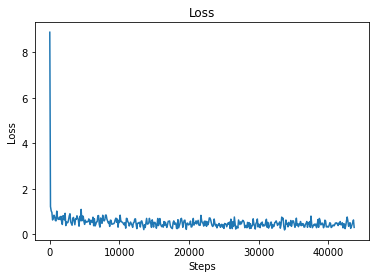

In [ ]:
# Plotting the loss over time
import matplotlib.pyplot as plt
   
steps = [i*100 for i in range(len(loss_per_10_steps))]
  
plt.plot(steps, loss_per_10_steps)
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

The model is finetuned and saved. We don't have to finetune it each time. We can load it from the saved file with config.json

In [ ]:
#Downloading the config file
!wget https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json


--2022-03-22 15:08:17--  https://s3.amazonaws.com/models.huggingface.co/bert/t5-base-config.json
Resolving s3.amazonaws.com (s3.amazonaws.com)... 54.231.139.168
Connecting to s3.amazonaws.com (s3.amazonaws.com)|54.231.139.168|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1199 (1.2K) [application/json]
Saving to: ‘t5-base-config.json.2’

t5-base-config.json 100%[===================>]   1.17K  --.-KB/s    in 0s      

2022-03-22 15:08:17 (45.7 MB/s) - ‘t5-base-config.json.2’ saved [1199/1199]



In [ ]:
from google.colab import files
files.download('t5-base-config.json') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

We got all we need to generate text. All we need to do is to upload the finetuned model from saved directory.

We are going to generate our stories in the Part 3. 

In [ ]:
#Loading the trained model from the path

model = T5ForConditionalGeneration.from_pretrained('/content/gdrive/My Drive/KRW_P5-2/pytoch_model.bin', 
                                                   return_dict=True,
                                                   config='/content/gdrive/My Drive/KRW_P5-2/t5-base-config.json')

In [ ]:
tokenizer = T5Tokenizer.from_pretrained('t5-base')

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

In [ ]:
#function to generate text

def generate(text):
  model.eval()
  input_ids = tokenizer.encode("WebNLG:{} </s>".format(text), return_tensors="pt")  # Batch size 1
  #input_ids.to(dev)
  s = time.time()
  outputs = model.generate(input_ids)
  gen_text=tokenizer.decode(outputs[0]).replace('<pad>','').replace('</s>','')
  elapsed = time.time() - s
  #print('Generated in {} seconds'.format(str(elapsed)[:4]))

  
  return gen_text

#Gossip Time: Let's generate a story!

In [ ]:
generate('Brad Pitt | given name | William Bradley Pitt')

' William Bradley Pitt is the name of the given name of Brad Pitt.'

In [ ]:
generate('Brad Pitt | born in | 18 December 1963')

' Brad Pitt was born in 18 December 1963.'

In [ ]:
generate('Brad Pitt | is a | American actor')

' Brad Pitt is an American actor.'

In [ ]:
generate("Brad Pitt | starred in | Fight Club")

' Brad Pitt starred in the Fight Club.'

A gossip story consists of two sections:
1. Introduction: Here we introduce the characters. Name, occupation, origin etc, how they are connected e.g. starred in the same movie, have a mutual child etc.
2. The gossip: here we state the news, e.g. Two celebrities have been seen together. Are they coming back together? etc. 

The first example:

The characters:

1. Brad Pitt Triples: 

  Brad Pitt | given name | William Bradley Pitt, 
  Brad Pitt | born in | 18 December 1963, 
  Brad Pitt | is a | American actor, 
  Brad Pitt | starred in | Fight Club, 
  Brad Pitt | starred in | Joe Black, 
  Brad Pitt | starred in | Ocean's Eleven, 
  Brad Pitt | starred in | Mr. & Mrs. Smith, 
  Brad Pitt | number of children | 6, 
  Brad Pitt | current status | single, 
  Brad Pitt | spouse | Jennifer Aniston, 
  Brad Pitt spouse Jennifer Aniston | start date | 29 July 2000, 
  Brad Pitt spouse Jennifer Aniston | end date | 2 October 2005, 
  Brad Pitt | divorced | Jennifer Aniston, 
  Brad Pitt | spouse | Angelina Jolie, 


2. Angelina Jolie:
  Triples:

3. Jennifer Anniston: 
  Triples:

4. The gossip: They have seen together. Are they coming back together? 
  Triples: 


The triples will be compiled in a list and for each triple, a sentence will be generated and that will be the story:

To be continued ...

In [ ]:
brad_pitt_triples = ["Brad Pitt | given name | William Bradley Pitt", "Brad Pitt | born in | 18 December 1963", 
                     "Brad Pitt | is a | American actor", "Brad Pitt | starred in | Fight Club and Ocean's Eleven and Joe Black", 
                     "Brad Pitt | awarded with | several Academy and Golden Globe awards etc. "]

In [ ]:
for triple in brad_pitt_triples:
  text = generate(triple)
  print(text)

 William Bradley Pitt is the name of the given name of Brad Pitt.
 Brad Pitt was born in 18 December 1963.
 Brad Pitt is an American actor.
 Brad Pitt starred in the Fight Club and Ocean's Eleven and Joe Black
 Brad Pitt was awarded with the Academy and Golden Globe awards.


In [ ]:
jennifer_anniston_triples = ["Jennifer Aniston | birth name | Jennifer Joanna Aniston", "Jennifer Aniston | age | 53", "Jennifer Aniston | starred in | American sitcom Friends",
                             "Jennifer Aniston | played | character: Rachel"]
for triple in jennifer_anniston_triples:
  text = generate(triple)
  print(text)

 Jennifer Joanna Aniston is the birth name of Jennifer Aniston.
 The age of Jennifer Aniston is 53.
 The character of Jennifer Aniston starred in the American sitcom Friends.
 The character of Jennifer Aniston is Rachel.


In [ ]:
angelina_jolie_triples = ["Angelina Jolie | birth name | Angelina Jolie Voight", "Angelina Jolie | born in | 4 June 1975", "Angelina Jolie | occupation | actress and humanitarian",
                          "Angelina Jolie | played in |  Lara Croft: Tomb Raider "]
for triple in angelina_jolie_triples:
  text = generate(triple)
  print(text)

 Angelina Jolie Voight is the birth name of Angelina Jolie.
 Anelina Jolie was born in June 25, 1974.
 Angelina Jolie is an actress and humanitarian.
 Anelina Jolie played in Lara Croft Tomb Raider.


In [ ]:
romance_life_triples = ["Brad Pitt | ex-spouse | Jennifer Aniston", "Brad Pitt | divorced | Jennifer Aniston", "Brad Pitt | married | Angelina Jolie ", 
                        "Brad Pitt | has children with | Angelina Jolie", "Brad Pitt | has children | 6 ", "Brad Pitt | broke up with | Angelina Jolie", 
                        "Brad Pitt | seen together | Jennifer Aniston ", "Brad Pitt | back together ? | who"]

for triple in romance_life_triples:
  text = generate(triple)
  print(text)

 The ex-spouse of Brad Pitt is Jennifer Aniston.
 Brad Pitt was divorced by Jennifer Aniston.
 Brad Pitt was married to Angelina Jolie.
 Angelina Jolie is a child of Brad Pitt.
 Brad Pitt has 6 children.
 Brad Pitt was broken up with Angelina Jolie.
 Brad Pitt and Jennifer Aniston are both a series of films.
 Brad Pitt is back together.


End of a very bad story :) 

##Lets read triples from our knowledgebase and generate text:

In [ ]:
import numpy as np

In [ ]:
KB_df=pd.read_csv('/content/gdrive/My Drive/KRW_P5-2/MatchesLink_toy3.tsv', index_col=[0], sep="\t")
KB_df = KB_df.fillna(value=np.nan)
#Let's inspect the dataset:
KB_df.head

<bound method NDFrame.head of               entity 1           entity 2  connected  \
0   Scarlett_Johansson      Harry_Knowles       True   
1        Justin_Bieber  Jennifer_Lawrence       True   
2           Alia_Bhatt       Pawan_Kalyan       True   
3     Jennifer_Aniston   Robert_Pattinson       True   
10       Vicky_Kaushal        Phil_McGraw       True   
11           Tom_Hanks         Emma_Stone       True   
12     Keira_Knightley     Bradley_Cooper       True   
13      Dwayne_Johnson          Amy_Adams       True   
15             Madonna          Brad_Pitt       True   

                                      Triple Entity 1  \
0   ['Scarlett Johansson | amountWikiLinks | 416',...   
1   ['Justin Bieber | hasOccupation | Singer', 'Ju...   
2   ['Alia Bhatt | hasOccupation | Actress, singer...   
3   ['Jennifer Aniston | hasPartner | Brad Pitt', ...   
10  ['Vicky Kaushal | hasRelative | Sunny Kaushal'...   
11  ['Tom Hanks | hasOccupation | filmmaker', 'Tom...   
12  ['Keir

In [ ]:
entity1_list = KB_df["entity 1"].tolist()
entity2_list = KB_df["entity 2"].tolist()
entity1_triples = KB_df["Triple Entity 1"].tolist()
entity2_triples = KB_df["Triple Entity 2"].tolist()

In [ ]:
def remove_unwanted_chars(text):
  remove_list = ["[", "]", ")", "(", "'"]
  for char in text:
    if char in remove_list:
      text = text.replace(char, "")
  return text


In [ ]:
for line in entity2_triples:
  line = remove_unwanted_chars(line)
  line = line.split(",")
  #print(type(line))
  for triple in line:
    #print(type(triple))
    print(f'triple: {triple}')
  break

triple: Harry Knowles | hasPartner | 
triple:  Harry Knowles | birthPlace | Austin
triple:  Texas
triple:  Harry Knowles | hasPartner | Patricia Cho Jones
triple:  Harry Knowles | hasOccupation | Film critic
triple:  writer
triple:  Harry Knowles | lengthPage | 19979
triple:  Harry Knowles | birthDate | 1971-12-11
triple:  Harry Knowles | amountWikiLinks | 70


Gossip template:

According to our birds, there might be something going on between {Entity1} and {Entity2}. Since they have recently been seeing in toch quite a lot. 

Let us give you some background about {Entity1} and {Entity2}:

Verbalize the triple about {Entity1}.

Verbalize the triple about {Entity1}.

So, what do you think? Are the rumours true about {Entity1} and {Entity2}?


In [ ]:
for ent1, ent2 in zip(entity1_list, entity2_list):
  ent1 = ent1.replace("_", " ")
  ent2 = ent2.replace("_", " ")
  print(ent1)
  print(ent2)
  break

Scarlett Johansson
Harry Knowles


In [ ]:
ent1_triples_for_generation = []
for line in entity1_triples:
  line = remove_unwanted_chars(line)
  line = line.split(",")
  #print(type(line))
  for triple in line:
    #print(type(triple))
    #print(f'triple: {triple}')
    ent1_triples_for_generation.append(triple)
  break

print(ent1_triples_for_generation)

['Scarlett Johansson | amountWikiLinks | 416', ' Scarlett Johansson | hasPartner | Romain Dauriac', ' Scarlett Johansson | hasOccupation | Actress', ' Scarlett Johansson | birthPlace | New York City', ' Scarlett Johansson | birthDate | 1984-11-22', ' Scarlett Johansson | hasRelative | Ejner Johansson', ' Scarlett Johansson | lengthPage | 189481', ' Scarlett Johansson | hasPartner | Colin Jost', ' Scarlett Johansson | hasPartner | ', ' Scarlett Johansson | hasOccupation | singer', ' Scarlett Johansson | hasPartner | Ryan Reynolds', ' Scarlett Johansson | hasOccupation | ']


In [ ]:
ent1_text = []
for triple in ent1_triples_for_generation:
  text = generate(triple)
  ent1_text.append(text)
print(ent1_text)

[' The amount of the amount of Wikilinks for Carlett Johansson is', ' Romain Dauriac is a part of Scarlett Johansson.', " Actress is the name of Scarlett Johansson's occupation.", ' Scarlett Johansson was born in New York City.', ' Scarlett Johansson was born on November 22nd 1984.', ' Ejner Johansson is the relative of Scarlett Johansson.', ' Scarlett Johansson is 189481 m long.', ' Colin Jost is a member of Scarlett Johansson, which has', ' Scarlett Johansson has a party called Scarlett Johansson', ' Scarlett Johansson has a singer as one of its ccupations', ' Ryan Reynolds is a member of Scarlett Johansson.', ' Scarlett Johansson has an Occupation of Scarlett Johan']


In [ ]:
ent2_triples_for_generation = []
for line in entity2_triples:
  line = remove_unwanted_chars(line)
  line = line.split(",")
  #print(type(line))
  for triple in line:
    #print(type(triple))
    #print(f'triple: {triple}')
    ent2_triples_for_generation.append(triple)
  break

print(ent2_triples_for_generation)

['Harry Knowles | hasPartner | ', ' Harry Knowles | birthPlace | Austin', ' Texas', ' Harry Knowles | hasPartner | Patricia Cho Jones', ' Harry Knowles | hasOccupation | Film critic', ' writer', ' Harry Knowles | lengthPage | 19979', ' Harry Knowles | birthDate | 1971-12-11', ' Harry Knowles | amountWikiLinks | 70']


In [ ]:
ent2_text = []
for triple in ent2_triples_for_generation:
  text = generate(triple)
  ent2_text.append(text)
print(ent2_text)

[' Harry Knowles has a party called Hardry Knowles.', ' Harry Knowles was born in Austin.', ' Texas is the location of Texas.', ' The character of Harry Knowles is Patricia Cho Jones.', ' Harry Knowles has a film character called Film Crim.', ' The writer of the novel "Aloy" is the author of the novel.', ' Harry Knowles is a length of the book "979"', ' Harry Knowles was born on December 11th 1971 and was born on December 11th 1971.', ' Harry Knowles has an amount of Wikilinks of 70.']


In [ ]:
with open("the_first_story.txt", "w") as f:
  f.write(f"According to our birds, there might be something going on between {ent1} and {ent2}. \nSince they have recently been seen in touch quite a lot.")
  f.write(f"\nLet us give you some background about {ent1} and {ent2}:")
  f.write(f"\n{ent1}:")
  for sent1 in ent1_text:
    f.write("\n"+sent1)
  f.write(f"\n{ent2}:")
  for sent2 in ent2_text:
    f.write(sent2+"\n")
  f.write(f"So, what do you think? Are the rumours true about {ent1} and {ent2}?")

In [ ]:
from google.colab import files
files.download('the_first_story.txt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>